In [1]:
#from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import UnivariateSpline
import math 
import matplotlib.pyplot as plt
import numpy as np
import scipy.io


## The following cell Loads all the data necessary for the question

### All data file description
<strong>'treecovdata.nc'</strong> contains the datastructure that can plot the world map

<strong>'2023worldforestdata.mat'</strong>  contains all the past and current rainfall data (1999, 2014, 2100), as well as the past forest cover (1999). Moreover, this file also contains the latitudes and longitudes of the world map for plotting. Note: latitude and longitudes are described as (1 X N) array but in the cell below we convert it into a squeezed array

<strong> worldfixedpointdata.mat </strong> file contains the hysterisis/fixedpoint data of 3 continents.

The variable named <strong> fixedpointdata_xyz </strong>as a (K X 4) numpy array. 'K' represents the total number of fixed points. Each row contains the following 4 columns:
- column 1: the amount of rainfall
- column 2: minimum stable fixed point
- column 3: maximum stable fixed point (if none then it contains 'Nan')
- column 4: the unstable fixed point (if none then it contains 'Nan')

In [2]:
fname = './treecovdata.nc'
fname_mat = './2023worldforestrainfalldata.mat'
mat_file = scipy.io.loadmat(fname_mat)

rainfall1999 = mat_file['rainfall1999']
rainfall2014 = mat_file['rainfall2014']
rainfall2100 = mat_file['rainfall2100']
forest1999 = mat_file['forest1999']
lats = np.squeeze(mat_file['lats'], axis=0)
lons = np.squeeze(mat_file['lons'],axis=0)

In [3]:
fname_mat = './worldfixedpointdata.mat'
mat_file = scipy.io.loadmat(fname_mat)
fixedpointdata_southamerica = mat_file['fixedpointdata_southamerica']
fixedpointdata_africa = mat_file['fixedpointdata_africa']
fixedpointdata_aus = mat_file['fixedpointdata_aus']

## Above code has loaded all variables of interest into the given variables:

- rainfall1999
- rainfall2014
- rainfall2100

- forest1999
- lats
- lons
- fixedpointdata_southamerica
- fixedpointdata_africa
- fixedpointdata_aus

## Plotting the equilibrium/hysterisis curve of the three continents (from fixedpointdata_XYZ variables)

 - stable points are denoted by circle marker
 - unstable points are denoted by (+) markers

In [ ]:
plt.figure(figsize=(10, 4))

nb_of_second_stable_sa=0
nb_of_second_stable_af=0
nb_of_second_stable_au=0
for i in range(fixedpointdata_aus.shape[0]):
    # print(fixedpointdata_aus[i,0])
    plt.subplot(1,3,1) # South america
    plt.plot(fixedpointdata_southamerica[i,0], fixedpointdata_southamerica[i,1], 'k.')
    plt.plot(fixedpointdata_southamerica[i,0], fixedpointdata_southamerica[i,2], 'k.')
    plt.plot(fixedpointdata_southamerica[i,0], fixedpointdata_southamerica[i,3], 'k+')
    plt.ylabel('tree cover (%)')
    plt.xlabel('rainfall (mm/yr)')
    
    plt.subplot(1,3,2) # Africa 
    plt.plot(fixedpointdata_africa[i,0], fixedpointdata_africa[i,1], 'k.')
    plt.plot(fixedpointdata_africa[i,0], fixedpointdata_africa[i,2], 'k.')
    plt.plot(fixedpointdata_africa[i,0], fixedpointdata_africa[i,3], 'k+')
    plt.xlabel('rainfall (mm/yr)')
    
    plt.subplot(1,3,3) # Australasia
    plt.plot(fixedpointdata_aus[i,0], fixedpointdata_aus[i,1], 'k.')
    plt.plot(fixedpointdata_aus[i,0], fixedpointdata_aus[i,2], 'k.')
    plt.plot(fixedpointdata_aus[i,0], fixedpointdata_aus[i,3], 'k+')
    plt.xlabel('rainfall (mm/yr)')


In [4]:
import numpy as np
from scipy.interpolate import CubicSpline as spline


def unpack(x):
    return x[0][0]

vunpack = np.vectorize(unpack)



def create_eq(y, eq_min, eq_max):
        eq = np.full_like(y[:, 0], np.nan)
        eq[(y[:, 0] >= eq_min) & (y[:, 0] <= eq_max)] = y[(y[:, 0] >= eq_min) & (y[:, 0] <= eq_max), 0]
        eq[(y[:, 1] >= eq_min) & (y[:, 1] <= eq_max)] = y[(y[:, 1] >= eq_min) & (y[:, 1] <= eq_max), 1]
        eq[(y[:, 2] >= eq_min) & (y[:, 2] <= eq_max)] = y[(y[:, 2] >= eq_min) & (y[:, 2] <= eq_max), 2]
        return eq



def create_function_eq(x, eq, last = False):
    x = x[~np.isnan(eq)]
    eq = eq[~np.isnan(eq)]
    uh = UnivariateSpline(x, eq, k=3, s=100)

    def f(z):
        if last: 
            if (z < x[0]) : return np.nan
            elif (z > x[-1]) : return eq[-1]
            else: return  uh(z)
        else : return np.nan if (z < x[0]) or (z > x[-1]) else uh(z)

    return np.vectorize(f)









## To separately compute forest cover on each continent, we are providing the coordiantes of the 3 continents. These three continents vary only in their range of longitudes while the latitudes are constant across the data.

In [5]:
# longitudes of southamerica, africa and australia [lower boundary value, laster boundary value]
lons_sa = [-90, -30] # South america coordinates (longitude range)
lons_af = [-30, 60] # African coordinates (longitude range)
lons_au = [60, 160] # Australia coordinates (longitude range)       

In [8]:
# useful variables/functions to compute the forest cover of each continent in 2100

row,col=rainfall2100.shape

# we have values of R at equilibirum only for multiples of 25
def get_rainfall_index(r):
    available_rainfall = np.arange(-25,2526,50)  # from -25 to 2525 with step 50
    return np.argmin(np.abs(available_rainfall-r))

def unpack(T):
    return T[0][0]

vunpack = np.vectorize(unpack)



def compute_forest2100(fixedpointdata, Lons):
    forest2100=np.full((row,col),np.nan)
    for i in range (row):
        for j in range(col):
            if(Lons[0]<=lons[j]<=Lons[1]):
                if(np.isnan(rainfall2100[i,j])): continue
                index = get_rainfall_index(rainfall2100[i,j])
                T_arr = vunpack(fixedpointdata[index][1:2])
                T_arr = T_arr[np.logical_not(np.isnan(T_arr))]
                print(T_arr)
                T_init = forest1999[i,j]
                forest2100[i,j] = T_arr[np.abs(T_arr - T_init).argmin()]
     
            
    return forest2100


            




In [ ]:
x = vunpack(fixedpointdata_africa[:,0])
y = vunpack(fixedpointdata_africa[:,1:])


def extract_eq_for_africa(y, eq_min, eq_max):
    eq = np.full_like(y, np.nan)
    eq[(y>= eq_min) & (y <= eq_max)] = y[(y >= eq_min) & (y <= eq_max)]
    y[(y >= eq_min) & (y <= eq_max)] = np.nan
    return eq

def create_function_eq_africa(f1, f2, f3):
    def f_new(z):
        F = np.array([f1(z), f2(z), f3(z)])
        F = F[~np.isnan(F)]
        if (F.size == 0): return np.nan
        return F[0]
    return np.vectorize(f_new)


# strange_eq1 = extract_eq_for_africa(y[:,0],60, 70)
# strange_eq2 = extract_eq_for_africa(y[:,0],30, 40)
# eq1 = create_eq(y, 0, 20)
# eq2 = create_eq(y, 20, 70)
# eq3 = create_eq(y, 70, 100)

f_eq1 = create_function_eq(x, y[:,1])
f_eq2 = create_function_eq(x, y[:,2])
f_eq3 = create_function_eq(x, y[:,0], last = True)
# f_strange_eq1 = create_function_eq(x, strange_eq1)
# f_strange_eq2 = create_function_eq(x, strange_eq2, last = True)
# f_eq3 = create_function_eq_africa(f_eq3, f_strange_eq1, f_strange_eq2)
x_test = np.linspace(0, 2600, 1000)

# print(f_eq3(x_test))
plt.plot(x_test, f_eq1(x_test))
plt.plot(x_test, f_eq2(x_test))
# plt.plot(x_test, f_eq3(x_test))
plt.plot(x, y[:,0], 'k.')
plt.plot(x, y[:,1], 'k.')
plt.plot(x, y[:,2], 'k.')
# plt.plot(x, strange_eq1, 'k.')
# plt.plot(x, strange_eq2, 'k.')
plt.show()

F = lambda z : np.array([f_eq1(z), f_eq3(z), f_eq2(z)])


# Here compute the forest cover in south america, given the rainfall amount at 2100 and the hysterisis/equilibrium curve fixedpointdata_southamerica
forest2100_africa=np.full((row,col),np.nan)
for i in range (row):
    for j in range(col):
        if(lons_af[0]<=lons[j]<=lons_af[1]):
            if(np.isnan(rainfall2100[i,j])): continue
            # index = get_rainfall_index(rainfall2100[i,j])
            T_arr = F(rainfall2100[i,j])
            # print(rainfall2100[i, j])
            # print(rainfall2100[i, j], T_arr)
            T_arr = T_arr[np.logical_not(np.isnan(T_arr))]
            # print(rainfall2100[i, j],T_arr)
            T_init = forest1999[i,j]
            forest2100_africa[i,j] = T_arr[np.abs(T_arr - T_init).argmin()]
            # print(forest2100_africa[i,j])
            # print(forest2100_america[i,j])
    
test = np.reshape(forest2100_africa, (row*col, 1))
plt.hist(test[~np.isnan(test)], bins = 100)
plt.show()

# print("\n\\n\n")
# forest2100=compute_forest2100(fixedpointdata_southamerica, lons_sa)
# forest2100_america=compute_forest2100(fixedpointdata_southamerica, lons_sa)
# NOTE: for computing the forest cover of south america, ignore what happens to the rest of the world. i.e., the rest-of-the-world map forest cover can be zeros or nan values

## The cell below plots the forest cover in south america from the value provided in forest2100

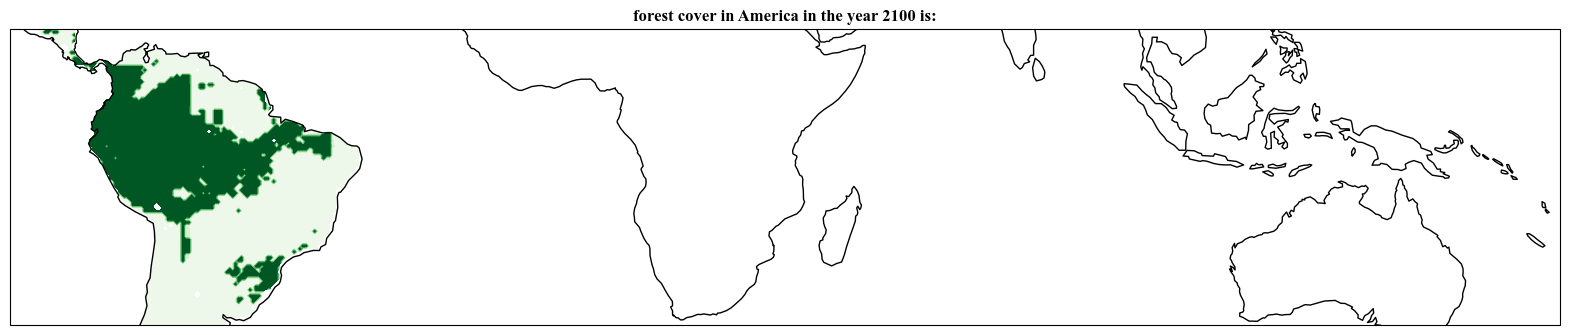

In [11]:
forest1999_america=np.full((row,col),np.nan)
mask = np.logical_and(lons >= lons_sa[0], lons <= lons_sa[1])
forest1999_america[:, mask] = forest1999[:, mask]

# # Forest cover in 1999 in South America
# fig = plt.figure(figsize=(20, 20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
# cs=plt.contourf(lons, lats, forest1999_america, cmap='Greens')  
# # fig.colorbar(cs)
# plt.title('forest cover in America in the year 1999 is:', fontname="Times New Roman", fontweight="bold")
# ax.coastlines()   
    

# Forest cover in 2100 in South America
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
cs=plt.contourf(lons, lats, forest2100_america, cmap='Greens')  
# fig.colorbar(cs)
plt.title('forest cover in America in the year 2100 is:', fontname="Times New Roman", fontweight="bold")
ax.coastlines()   

In [ ]:
# rainfall1999_america=np.full((row,col),np.nan)
# rainfall2100_america=np.full((row,col),np.nan)

# mask = np.logical_and(lons >= lons_sa[0], lons <= lons_sa[1])
# rainfall1999_america[:, mask] = rainfall1999[:, mask]
# rainfall2100_america[:, mask] = rainfall2100[:, mask]
# # Forest cover in 1999 in South America
# fig = plt.figure(figsize=(20, 20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
# cs=plt.contourf(lons, lats, rainfall1999_america, cmap='Blues')  
# #fig.colorbar(cs)
# plt.title('forest cover in America in the year 1999 is:', fontname="Times New Roman", fontweight="bold")
# ax.coastlines()   
    

# # Forest cover in 2100 in South America
# fig = plt.figure(figsize=(20, 20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
# cs=plt.contourf(lons, lats, rainfall2100_america, cmap='Blues')  
# #fig.colorbar(cs)
# plt.title('forest cover in America in the year 2100 is:', fontname="Times New Roman", fontweight="bold")
# ax.coastlines()  

In [12]:
# Here compute the forest cover in africa, given the rainfall amount at 2100 and the hysterisis/equilibrium curve fixedpointdata_africa
# Place the computed forest cover in the variable named 'forest2100'




x = vunpack(fixedpointdata_southamerica[:,0])
y = vunpack(fixedpointdata_southamerica[:,1:])


eq1 = create_eq(y, 0, 20)
eq2 = create_eq(y, 20, 70)
eq3 = create_eq(y, 70, 100)

f_eq1 = create_function_eq(x, eq1)
f_eq2 = create_function_eq(x, eq2)
f_eq3 = create_function_eq(x, eq3, last=True)



F = lambda z : np.array([f_eq1(z), f_eq3(z)])


# Here compute the forest cover in south america, given the rainfall amount at 2100 and the hysterisis/equilibrium curve fixedpointdata_southamerica
forest2100_america=np.full((row,col),np.nan)
for i in range (row):
    for j in range(col):
        if(lons_sa[0]<=lons[j]<=lons_sa[1]):
            if(np.isnan(rainfall2100[i,j])): continue
            # index = get_rainfall_index(rainfall2100[i,j])
            T_arr = F(rainfall2100[i,j])
            # print(rainfall2100[i, j], T_arr)
            # print(rainfall2100[i, j])
            T_arr = T_arr[np.logical_not(np.isnan(T_arr))]
            # print(rainfall2100[i, j],T_arr)
            T_init = forest1999[i,j]
            forest2100_america[i,j] = T_arr[np.abs(T_arr - T_init).argmin()]
            # print(forest2100_america[i,j]) # stable equilibrium which is the closest to the intial value of T


test = np.reshape(forest2100_america, (row*col, 1))
plt.hist(test[~np.isnan(test)], bins = 100)
plt.show()
# NOTE: for computing the forest cover of africa, ignore what happens to the rest of the world. . i.e., the rest-of-the-world map forest cover can be zeros or nan values

NameError: name 'lats_sa' is not defined

## The cell below plots the forest cover in africa from the value provided in forest2100

In [ ]:
# forest1999_africa=np.full((row,col),np.nan)
# mask = np.logical_and(lons >= lons_af[0], lons <= lons_af[1])
# forest1999_africa[:, mask] = forest1999[:, mask]

# # Forest cover in 1999 in africa
# fig = plt.figure(figsize=(20, 20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
# cs=plt.contourf(lons, lats, forest1999_africa, cmap='Greens')  
# #fig.colorbar(cs)
# plt.title('forest cover in Africa in the year 1999 is:', fontname="Times New Roman", fontweight="bold")
# ax.coastlines()   
    
# # Forest cover in 2100 in africa
# fig = plt.figure(figsize=(20, 20))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
# cs=plt.contourf(lons, lats, forest2100, cmap='Greens', vmin=0)  
# #fig.colorbar(cs)
# plt.title('forest cover in Africa in the year 2100 is:', fontname="Times New Roman", fontweight="bold")
# ax.coastlines()   

In [ ]:
# Here compute the forest cover in australia+asia (australasia), given the rainfall amount at 2100 and the hysterisis/equilibrium curve fixedpointdata_aus
# Place the computed forest cover in the variable named 'forest2100'

x = vunpack(fixedpointdata_aus[:,0])
y = vunpack(fixedpointdata_aus[:,1:])

eq1 = create_eq(y, 0, 20)
eq2 = create_eq(y, 20, 70)
eq3 = create_eq(y, 70, 100)

f_eq1 = create_function_eq(x, eq1)
f_eq2 = create_function_eq(x, eq2)
f_eq3 = create_function_eq(x, eq3, last=True)

x_test = np.linspace(0, 2600, 1000)

plt.plot(x_test, f_eq1(x_test))
plt.plot(x_test, f_eq2(x_test))
plt.plot(x_test, f_eq3(x_test))
plt.plot(x, y[:,0], 'k.')
plt.plot(x, y[:,1], 'k.')
plt.plot(x, y[:,2], 'k.')
plt.show()

F = lambda z : np.array([f_eq1(z), f_eq3(z)])


# Here compute the forest cover in south america, given the rainfall amount at 2100 and the hysterisis/equilibrium curve fixedpointdata_southamerica
forest2100_aus=np.full((row,col),np.nan)
for i in range (row):
    for j in range(col):
        if(lons_au[0]<=lons[j]<=lons_au[1]):
            if(np.isnan(rainfall2100[i,j])): continue
            # index = get_rainfall_index(rainfall2100[i,j])
            T_arr = F(rainfall2100[i,j])
            # print(rainfall2100[i, j])
            T_arr = T_arr[np.logical_not(np.isnan(T_arr))]
            # print(rainfall2100[i, j],T_arr)
            T_init = forest1999[i,j]
            forest2100_aus[i,j] = T_arr[np.abs(T_arr - T_init).argmin()]
            # print(forest2100_america[i,j])# stable equilibrium which is the closest to the intial value of T
                    
# NOTE: for computing the forest cover of australasia, ignore what happens to the rest of the world. i.e., the rest-of-the-world map forest cover can be zeros or nan values

In [ ]:
forest2100 = [forest2100_america, forest2100_africa, forest2100_aus]

# cmap = LinearSegmentedColormap.from_list(
#     'Custom cmap', ['#ffffff', '#e5f5e0', '#a1d99b', '#31a354'], N=256)
# Forest cover in 1999 in Australasia
fig = plt.figure(figsize=(15, 12))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 0.05], hspace=0.05)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
# First subplot for the year 1999
ax1.set_extent([min(lons), max(lons), min(lats), max(lats)], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.OCEAN, alpha = .7)
cs1 = ax1.contourf(lons, lats, forest1999, cmap='Greens', vmin=0, vmax=80, levels=np.linspace(0, 80, 80))
ax1.set_title('Forest Cover in 1999', fontsize = 14)
ax1.coastlines(resolution='110m', color='black', linewidth=1)
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Second subplot for the year 2100
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax2.set_extent([min(lons), max(lons), min(lats), max(lats)], crs=ccrs.PlateCarree())
for forest in forest2100:
    cs2 = ax2.contourf(lons, lats, forest, cmap="Greens", vmin=0, vmax=80, levels=np.linspace(0, 80, 80))
ax2.add_feature(cfeature.OCEAN, alpha = 0.7)
ax2.set_title('Forest Cover in 2100', fontsize = 14)
ax2.coastlines(resolution='110m', color='black', linewidth=1)
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

cax = fig.add_subplot(gs[2])
cbar = plt.colorbar(cs2, cax=cax, orientation='horizontal', pad = 0.01)
cbar.set_label('Forest Cover (%)')
cbar_ticks = np.arange(0, 81, 10)  # Creates a list from 0 to 80 in steps of 10
cbar.set_ticks(cbar_ticks)  # Sets the positions of the ticks

# Optionally, set custom tick labels
cbar_ticklabels = [f'{tick}%' for tick in cbar_ticks]  # List comprehension to add '%' to each tick
cbar.set_ticklabels(cbar_ticklabels)  # Sets the text of the ticks
fig.subplots_adjust(top=0.95, bottom=0.35, left=0.05, right=0.95, hspace=0.02)
plt.show()

In [ ]:
rainfall2100_aus = np.full((row,col),np.nan)
rainfall2100_af   = np.full((row,col),np.nan)
rainfall2100_am   = np.full((row,col),np.nan)
mask1 = np.logical_and(lons >= lons_au[0], lons <= lons_au[1])
mask2 = np.logical_and(lons >= lons_af[0], lons <= lons_af[1])
mask3 = np.logical_and(lons >= lons_sa[0], lons <= lons_sa[1])


rainfall2100_aus[:,mask1] = rainfall2100[:,mask1]
rainfall2100_af [:,mask2] = rainfall2100[:,mask2]
rainfall2100_am [:,mask3] = rainfall2100[:,mask3]

rainfall = [rainfall2100_aus, rainfall2100_af, rainfall2100_am]


fig = plt.figure(figsize=(15, 12))

gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.05, 1, 0.05], hspace=0.05)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
# First subplot for the year 1999
ax1.set_extent([min(lons), max(lons), min(lats), max(lats)], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.OCEAN, alpha = .7)
cs1 = ax1.contourf(lons, lats, rainfall1999, cmap='Blues')
ax1.set_title('Forest Cover in 1999', fontsize = 14)
ax1.coastlines(resolution='110m', color='black', linewidth=1)
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(cs1, cax=cax, orientation='horizontal')
cbar.set_label('Rainfall (%)')
# Second subplot for the year 2100
ax2 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
ax2.set_extent([min(lons), max(lons), min(lats), max(lats)], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.OCEAN, alpha = .7)
for r in rainfall:
    cs2 = ax2.contourf(lons, lats, r, cmap="Blues")

ax2.add_feature(cfeature.OCEAN, alpha = 0.7)
ax2.set_title('Forest Cover in 2100', fontsize = 14)
ax2.coastlines(resolution='110m', color='black', linewidth=1)
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

cax = fig.add_subplot(gs[3])
cbar = plt.colorbar(cs2, cax=cax, orientation='horizontal')
cbar.set_label('Rainfall (%)')
# cbar_ticks = np.arange(0, 2535, 10)  # Creates a list from 0 to 80 in steps of 10
# cbar.set_ticks(cbar_ticks)  # Sets the positions of the ticks

# # Optionally, set custom tick labels
# cbar_ticklabels = [f'{tick}%' for tick in cbar_ticks]  # List comprehension to add '%' to each tick
# cbar.set_ticklabels(cbar_ticklabels)  # Sets the text of the ticks
fig.subplots_adjust(top=0.95, bottom=0.30, left=0.05, right=0.95, hspace=0.1)
plt.show()


In [ ]:
rainfall1999_aus=np.full((row,col),np.nan)
rainfall2100_aus=np.full((row,col),np.nan)

mask = np.logical_and(lons >= lons_au[0], lons <= lons_au[1])
rainfall1999_aus[:, mask] = rainfall1999[:, mask]
rainfall2100_aus[:, mask] = rainfall2100[:, mask]
# Forest cover in 1999 in South America
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
cs=plt.contourf(lons, lats, rainfall1999_aus, cmap='Blues')  
#fig.colorbar(cs)
plt.title('forest cover in America in the year 1999 is:', fontname="Times New Roman", fontweight="bold")
ax.coastlines()   
    

# Forest cover in 2100 in South America
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lons), max(lons), min(lats) , max(lats)], crs=ccrs.PlateCarree())
cs=plt.contourf(lons, lats, rainfall2100_aus, cmap='Blues')  
#fig.colorbar(cs)
plt.title('forest cover in America in the year 2100 is:', fontname="Times New Roman", fontweight="bold")
ax.coastlines()  